이 노트북은 김성훈 교수님의 모두를 위한 딥러닝 강좌 스크립트들을 참고, 재구성하여 만들어졌습니다.


(https://github.com/hunkim/DeepLearningZeroToAll)

Colab의 기본 텐서플로우 버전은 2.X이므로 1.X 버전으로 다운그레이드 해줍니다.

In [1]:
!pip uninstall tensorflow
!pip install tensorflow==1.15

Uninstalling tensorflow-2.2.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.2.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.2.0
     |████████████████████████████████| 412.3MB 35kB/s 
     |████████████████████████████████| 3.8MB 42.5MB/s 
     |████████████████████████████████| 512kB 44.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=d4e8a5763c7a39d34369a65f7d09078619d285c61b0b8a8b2375dc67f4e4914b
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have 

필요한 모듈들을 import합니다.

In [2]:
import tensorflow as tf
# 텐서플로우 패키지
import random
# 재현성을 위해 난수 Seed를 고정하기 위해 불러오는 패키지입니다.
from tensorflow.examples.tutorials.mnist import input_data
# 영상인식에서 대표적인 Dataset인 MNIST를 불러오고 사용하기 위한 패키지입니다.

하이퍼 패러미터와 난수 Seed를 설정합니다.

In [3]:
tf.set_random_seed(777)
# 재현성을 위해 난수를 고정합니다.

# Hyperparameters
# 하이퍼 패러미터란 학습으로 인해 자동으로 최적화되는 값이 아닌,
# 사람이 Huristic하게 최적의 값을 찾아나갈 수 밖에 없는 Parameter들입니다.
learning_rate = 0.001
# 한번에 얼만큼 업데이트 할 것인가에 대한 Hyperparameter입니다.
training_epochs = 15
# 에폭은 전체 데이터셋의 크기 만큼의 한 Loop를 일컫는 단위입니다. 총 몇 에폭 돌지 설정합니다.
batch_size = 100
# 한번에 Feed하는 이미지의 갯수를 결정합니다.
# 초심자 단계에서 당장 신경쓸 필요는 없지만 배치사이즈는 학습속도 뿐만 아니라 최종적인 성능에도 상당한 영향을 미친다고 알려져 있습니다.

MNIST 데이터셋은 텐서플로우에서 자체적으로 제공하므로 텐서플로우 API를 이용해 데이터를 불러옵니다.

In [4]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# 텐서플로우에서 지원하는 API를 사용합니다.
#"MNIST_data/"는 불러올 데이터셋의 디렉토리
# one_hot은 One-Hot 인코딩 형식으로 불러올지 여부를 결정합니다.

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

모델을 구성합니다. 딥러닝 소스코드의 심장에 해당하는 부분입니다.


텐서플로우 1.X는 정적그래프로 모델의 패러미터와 연산 관계를 직접 정의합니다.

In [5]:
X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None, 10])
# Placeholder란 데이터가 들어갈 미리 만들어 놓은 틀이라고 생각하면 됩니다.
# 정적 그래프 방식을 사용하는 텐서플로우 1.X 버전에서는 이처럼 미리 입력의 형태를 지정해 놓아야 합니다.

keep_prob = tf.placeholder(tf.float32)
# Dropout을 할 때 얼만큼 데이터를 보존할 지 결정하는 Parameter입니다.
# (1 - keep_prob)만큼 학습시에 데이터를 탈락시킵니다.
# 이후 Runtime중에 학습시엔 0.7, 평가시엔 1이 입력으로 들어가도록 할 것 입니다.

# 아래 부터 실제로 데이터가 흘러다닐 신경망을 정의하게 됩니다.
W1 = tf.get_variable("W1", shape=[784, 512],
                     initializer=tf.random_normal_initializer())
# Weight를 "W1"라는 이름으로, [784, 512]의 모양으로, 정규분포에서 초기화합니다.
b1 = tf.get_variable("b1", shape=[512],
                     initializer=tf.zeros_initializer())
# Bias를 "b1"라는 이름으로, [512]의 모양으로, 0으로 초기화합니다.
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
# 내적연산과 활성화함수를 정의함으로서 실질적으로 입력과 Weight, bias간의 연산이 일어나도록 하는 부분입니다.
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)
# Regularization을 위해 Dropout을 정의합니다.

# 위와 같은 방식으로 나머지 부분의 신경망을 정의합니다.
W2 = tf.get_variable("W2", shape=[512, 512],
                     initializer=tf.random_normal_initializer())
b2 = tf.get_variable("b2", shape=[512],
                     initializer=tf.zeros_initializer())
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

W3 = tf.get_variable("W3", shape=[512, 512],
                     initializer=tf.random_normal_initializer())
b3 = tf.get_variable("b3", shape=[512],
                     initializer=tf.zeros_initializer())
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)

W4 = tf.get_variable("W4", shape=[512, 512],
                     initializer=tf.random_normal_initializer())
b4 = tf.get_variable("b4", shape=[512],
                     initializer=tf.zeros_initializer())
L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)

W5 = tf.get_variable("W5", shape=[512, 10],
                     initializer=tf.random_normal_initializer())
b5 = tf.get_variable("b5", shape=[10],
                     initializer=tf.zeros_initializer())
hypothesis = tf.matmul(L4, W5) + b5
# hypothesis는 말 그대로 가설입니다. 내 모델을 통해 예측한 예측값(가설)이라고 생각하면 됩니다.
# Softmax를 거치기 전 Logit도 가설이라고 할 수 있고 Softmax를 거친 확률 값도 가설이라고 할 수 있습니다.

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hypothesis, labels=Y))
# Loss Function을 계산합니다. 
# Softmax 함수는 tf.nn.softmax_cross_entropy_with_logits안에 내부적으로 포함되어 있으므로 생략해도 됩니다.

train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
# 최적화엔 Adam Optimizer를 사용합니다.
# learning_rate=learning_rate로 Hyperparameter인 Learning Rate를 입력해줍니다.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



텐서플로우는 단일 GPU이고 텐서플로우 GPU버전이 설치되어 있을 경우, 별도의 코드 추가 없이도 자동으로 GPU 가속이 적용됩니다.

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
# GPU가 사용가능한지만 확인해줍니다.

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15870571390045029640, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5462346505183513445
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16673175122066565912
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7516987321663613157
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

텐서플로우는 정적으로 정의된 그래프에 Runtime중 실제 데이터를 흘려보내기 위해 Session이라는 객체를 사용합니다.

In [7]:
sess = tf.Session()
# 세션을 만듭니다.
sess.run(tf.global_variables_initializer())
# 모든 학습가능한 Parameter들을 초기화합니다.
# 앞서 tf.get_variable에 
# initializer=tf.random_normal_initializer()로 입력해놓은 부분은
# 실제로 Parameter가 초기화되는 부분이 아닌, Parameter를 어떤 방식으로 초기화 할지 정의하는 부분입니다.

트레이닝 루프를 만들어 줍니다. 실질적으로 학습이 진행되는 부분입니다.

In [8]:
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)
    # '전체 데이터셋 길이'를 '한번에 Feed하는 배치사이즈'로 나누면
    # 한 에폭을 돌기위해 반복해야 할 루프횟수(total_batch)가 됩니다.
    
    for i in range(total_batch):
      batch_xs, batch_ys = mnist.train.next_batch(batch_size)
      # 학습용 데이터셋에서 Input과 Label을 불러옵니다.
      # next_batch 함수는 데이터를 batch_size만큼 차례대로 잘라서 불러와 줍니다.
      
      c, _ = sess.run([cost, train_op], feed_dict={X: batch_xs, Y: batch_ys, keep_prob: 0.7})
      # 드디어 Session을 이용해 실제로 데이터를 흘려보내주는 부분입니다.
      # 앞서 만들어둔 Placeholder라는 틀 X, Y, keep_prob에
      # 실제 데이터인 batch_xs, batch_ys, 0.7이 Feed되는 모습에 주목하십시오.
      #
      # 'batch_xs, batch_ys, 0.7'과 'X, Y, keep_prob'이 '실제 데이터'와 '정적 그래프'의 관계이듯이,
      # 'c, _' 쌍과 'cost, train_op' 쌍은 '실제 데이터'와 '정적 그래프'의 관계입니다.
      # Session을 통해 정적 그래프로부터 실제 데이터를 얻는데,
      # 이때 train_op는 단순히 실행만 필요하고 반환은 필요없는 Operation일 뿐이므로
      # 앞으로 쓰지 않을 것이라는 뜻으로 '_'로 반환받습니다.

      avg_cost += c / total_batch
      # '실제 정답값과의 차이'가 얼마나 줄어들었는지 실시간으로 확인하기 위해 따로 기록해둡니다.

    print("[Epoch: %7d] cost = %5.5f"%(epoch + 1, avg_cost.item()))
    # '실제 정답값과의 차이'가 얼마나 줄어들었는지 실시간으로 확인합니다.

print('Learning Finished!')

[Epoch:       1] cost = 342813.15413
[Epoch:       2] cost = 85623.31996
[Epoch:       3] cost = 48130.94689
[Epoch:       4] cost = 31904.04662
[Epoch:       5] cost = 22829.69634
[Epoch:       6] cost = 16755.04607
[Epoch:       7] cost = 12801.80765
[Epoch:       8] cost = 9882.25287
[Epoch:       9] cost = 7716.67143
[Epoch:      10] cost = 5997.11277
[Epoch:      11] cost = 4639.49917
[Epoch:      12] cost = 3571.04835
[Epoch:      13] cost = 2760.34666
[Epoch:      14] cost = 2064.70456
[Epoch:      15] cost = 1532.40067
Learning Finished!


학습이 완료된 모델을 이용해 정확도(Accuracy)를 구해봅니다.

In [9]:
# 역시 정확도를 계산하는 정적 그래프를 먼저 정의합니다.
correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
# 먼저 맞게 예측되었는지 나타내는 bool 그래프를 정의합니다.
# tf.argmax(hypothesis, 1) : 확률이 가장 높은 값의 Index를 취합니다.
# tf.argmax(Y, 1)의 경우 One-Hot 인코딩이므로 정답인(확률이 1인) 값의 Index를 취할 것 입니다. 
# tf.equal로 정답값과 예측값을 비교하여 bool 형태로 반환합니다.

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# bool 데이터 타입은 reduce_mean 연산에 사용할 수 없으므로 float 데이터 타입으로 형변환 한 뒤,
# reduce_mean 연산을 해줍니다. 이렇게 하면 맞게 예측한 것들의 비율을 구하는 정적 그래프를 정의할 수 있습니다.

print('Accuracy:', sess.run(accuracy, feed_dict={
      X: mnist.test.images, Y: mnist.test.labels, keep_prob: 1}))
# 정적 그래프에 실제 평가용 데이터를 Feed해줍니다.
#  mnist.test.images, mnist.test.labels는 평가용 Input과 Label이고
# 평가시엔 Dropout을 적용하지 않으므로 keep_prob에 1을 Feed 해줍니다.

Accuracy: 0.8821


모델이 잘 작동하는지 예시 하나를 직접 눈으로 확인합니다

In [10]:
r = random.randint(0, mnist.test.num_examples - 1)
# 랜덤한 값 하나를 고릅니다.

print("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1))[0])
print("Prediction: ", sess.run(
    tf.argmax(hypothesis, 1), feed_dict={X: mnist.test.images[r:r + 1], keep_prob: 1})[0])
# 예측값과 정답을 비교해봅니다.

Label:  0
Prediction:  0


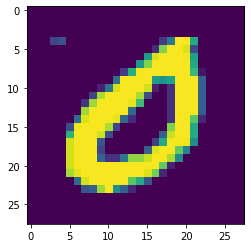

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(mnist.test.images[r:r + 1].reshape(28, 28))
# 예측에 사용했던 숫자의 이미지를 시각화 해봅니다.

위 과정을 모두 완료하셨으면 오버피팅 현상을 경험해보기 위해 학습을 더 시키고 정확도를 확인해 봅시다.